<!-- ![Alt text](Dublin_Skyline.png) -->

<img src="Dublin_Skyline.png" width="600"/>

# Tutorial notebook on **"Time series analysis for coupled neurons."**

## Resource: https://arxiv.org/abs/2507.13570

## Need to install packages

In [2]:
# we need nolds package
!pip install nolds

  Using cached nolds-0.6.2-py2.py3-none-any.whl.metadata (7.0 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
Using cached nolds-0.6.2-py2.py3-none-any.whl (225 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nolds]


In [1]:
# Import packages

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection 
from matplotlib.patches import Circle
from scipy.integrate import solve_ivp
import nolds as nd
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

## Single neuron model

$$\begin{aligned}
    \dot{x} &= f(x, y, I) = x^2(1-x) - y +I, \\
    \dot{y} &= g(x, y, I) = A e^{\alpha x} - \gamma y,\\
    \dot{I} & = h(x, y, I) =  \varepsilon\bigg[\frac{1}{60}\bigg\{1+\tanh\bigg(\frac{0.05-x}{0.001}\bigg)\bigg\} - I\bigg],
\end{aligned}$$

In [2]:
## Single Neuron simulation

## Parameters
A = 0.0041
alpha=5.276
gamma = 0.315
epsilon = 0.0005

## Define the function of differential equations
def system(t, vars):
    x1, y1, I1= vars
    dx1dt = x1**2 * (1 - x1) - y1 + I1
    dy1dt = A * np.exp(alpha * x1) - gamma * y1
    dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)

    return [dx1dt, dy1dt, dI1dt]

## Initial conditions
x1_0 = np.random.uniform(low=-1, high=1)
y1_0 = 0.1
I1_0 = 0.019

initial_conditions = [x1_0, y1_0, I1_0]


## Time span for the solution
t_span = (0, 4000)
t_eval = np.linspace(t_span[0], t_span[1], 50000)

## Solve
solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

## Extract solutions
x1_sol = solution.y[0]
y1_sol = solution.y[1]
I1_sol = solution.y[2]


tt = solution.t
print("done")


done


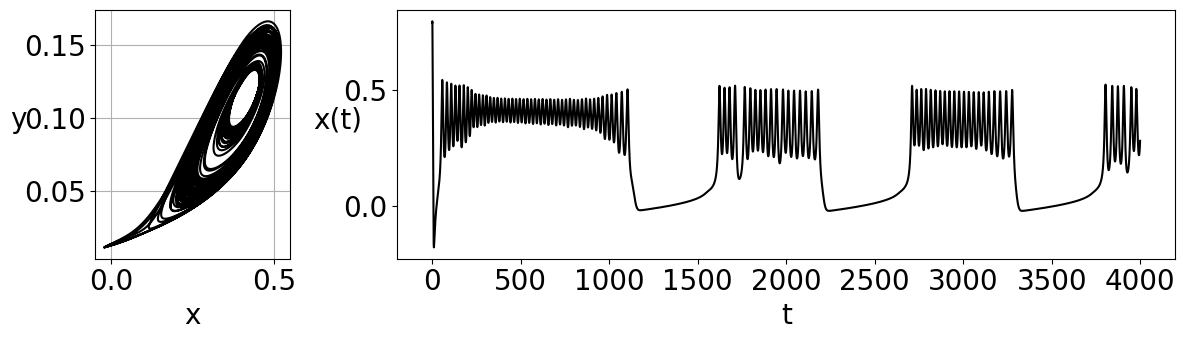

In [3]:
sz=20
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), gridspec_kw={'width_ratios': [1, 4]})


axs[0].plot(x1_sol[5000:], y1_sol[5000:], 'k-', ms =1, rasterized=True)
# axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
axs[0].set_xlabel('x', size=sz)
axs[0].set_ylabel('y', rotation = False, size=sz)
axs[0].tick_params(axis='both', labelsize=sz)
axs[0].grid()

axs[1].plot(tt, x1_sol, 'k-', ms=1, rasterized=True)
axs[1].set_ylabel('x(t)', size=sz, rotation=False)
axs[1].set_xlabel('t', size=sz)
axs[1].tick_params(axis='both', labelsize=sz)
plt.tight_layout()

## Gap Junction Coupling

<img src="gapSchem.png" width="300"/>

$\begin{aligned}
    \dot{x}_i &= f(x_i, y_i, I_i) + \sum_{j \in B(i)}\theta (x_j - x_i),\\
    \dot{y}_i &= g(x_i, y_i, I_i), \\
    \dot{I}_i & = h(x_i, y_i, I_i).
\end{aligned}$

In [20]:
## function to plot phase portraits, time series, and compute every metric for gap junction coupling

def bif_gap_pp(theta):
    ## parameter values
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005
    
    ## define the dynamical system to simulate
    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ theta*(x2-x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*(x1-x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    ## Initial conditions
    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]


    ## Time span for the solution
    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    ## Solving the system of differential equations
    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    ## Extract solutions
    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t
    
    ## cross-correlation coeff
    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("1. computing completed")
    
    ## Kuramoto order parameter
    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("2. computing completed")

    ## 0-1 test
    ## New time span for performing the 0-1 test
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)
    
    ## New solution
    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    ## Functions for 0-1 test 
    ## These have been converted from https://github.com/amitg7/01ChaosTest.jl by Anjana S Nair for her Masters project!

    def pq(phi, c):
        n = np.arange(len(phi))
        cosTerm = np.cos(c * n)
        sinTerm = np.sin(c * n)
        p = np.cumsum(phi * cosTerm)
        q = np.cumsum(phi * sinTerm)
        return p, q
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("3. computing completed")

    h1, h2, se1, se2 = nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)
    print("4. computing completed")
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2

In [21]:
def plotGapJunction(theta):
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_gap_pp(theta)
    
    sz=20
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
    fig.tight_layout()
    plt.suptitle(
        "$H=$" + str(round((h1 + h2) / 2, 4)) +
        ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
        ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
        ", $\Gamma=$" + str(round(cc, 4)) +
        ", $B=$" + str(round(Kuram, 4)),
        size=sz
    )
    
    axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
    # axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
    axs[0, 0].set_xlabel('$x_1$', size=sz)
    axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
    axs[0, 0].tick_params(axis='both', labelsize=sz)
    axs[0, 0].grid()
    
    axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
    # axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
    axs[1, 0].set_xlabel('$x_2$', size=sz)
    axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
    axs[1, 0].tick_params(axis='both', labelsize=sz)
    axs[1, 0].grid()
    
    axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
    axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
    axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
    axs[0, 1].tick_params(axis='both', labelsize=sz)
    axs[0, 1].grid()
    
    axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
    axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
    axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
    axs[1, 1].tick_params(axis='both', labelsize=sz)
    axs[1, 1].grid()
    
    axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
    axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
    axs[0, 2].set_xlabel('$t$', size=sz)
    axs[0, 2].tick_params(axis='both', labelsize=sz)
    
    axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
    axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
    axs[1, 2].set_xlabel('$t$', size=sz)
    axs[1, 2].tick_params(axis='both', labelsize=sz)
    
    plt.tight_layout()

0.49766521127520313 -0.5071266673836186
1. computing completed
2. computing completed
3. computing completed
4. computing completed


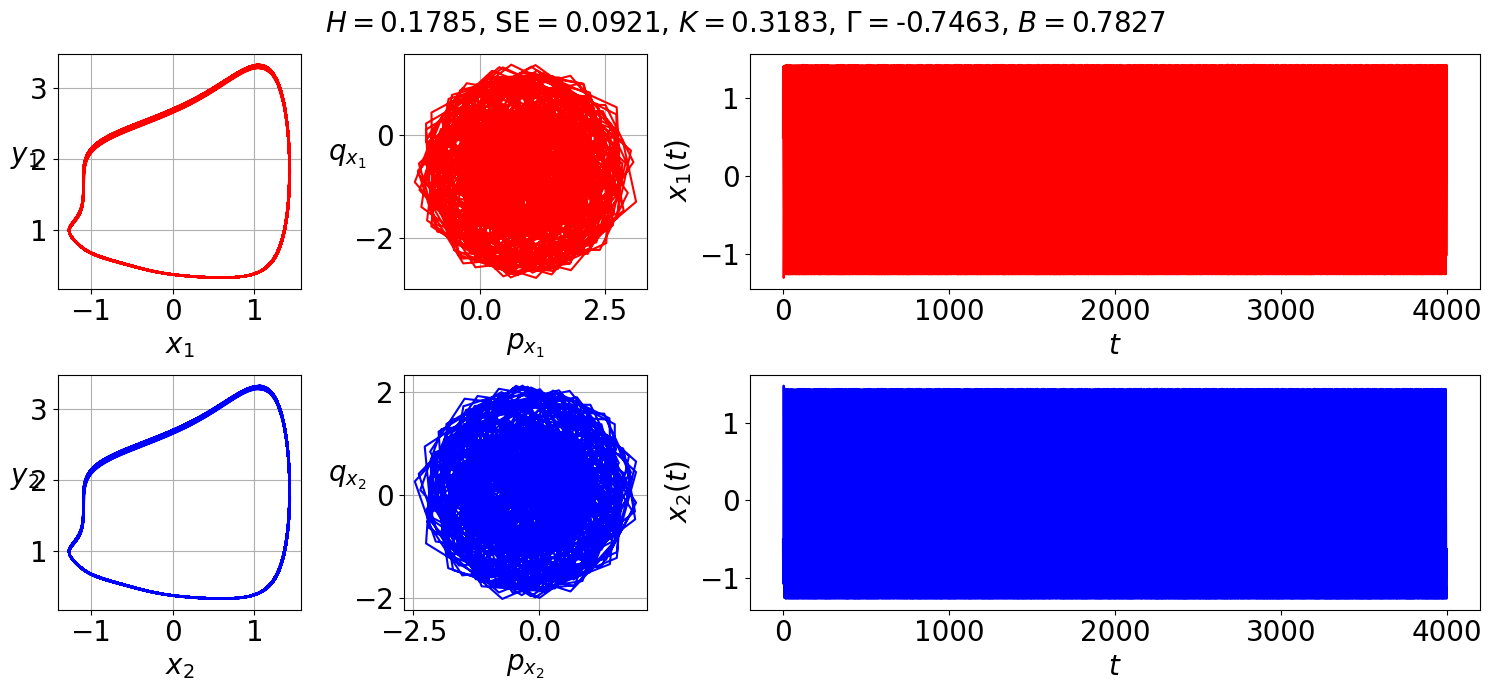

In [28]:
# theta = -10
# theta = -5
theta = -1
# theta = 1
# theta = 5
# theta = 10

plotGapJunction(theta)

## Chemical coupling

<img src="chemSchem.png" width="300"/>

$\begin{aligned}
    \dot{x}_1 &= f(x_1, y_1, I_1),\\
    \dot{x}_2 &= f(x_2, y_2, I_2) +\theta\frac{v_s - x_2}{1+\exp\{-\lambda(x_1 - q)\}},\\
    \dot{y}_i &= g(x_i, y_i, I_i), \\
    \dot{I}_i & = h(x_i, y_i, I_i),
\end{aligned}$

In [25]:
def bif_chem_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005
    vs = 2
    lamb = 10
    q = -0.25

    def system(t, vars):
        x1, y1, I1, x2, y2, I2= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*(vs-x2)/(1+np.exp(-lamb*(x1-q)))
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.019

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("1. computing completed")

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("2. computing completed")
    
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        n = np.arange(len(phi))
        cosTerm = np.cos(c * n)
        sinTerm = np.sin(c * n)
        p = np.cumsum(phi * cosTerm)
        q = np.cumsum(phi * sinTerm)
        return p, q
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("3. computing completed")

    h1, h2, se1, se2 = nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)
    print("4. computing completed")
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2

In [26]:
def plotChemical(theta):
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_chem_pp(theta)
    
    # phi_x1, phi_y1, phi_x2, phi_y2, KK1, se1, KK2, se2, kuram = [0.1, 0.2], [0.1, 0.2], [.1, .65], [0.1, 0.8], 1, 1, 1, 1, 1
    
    sz=20
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
    fig.tight_layout()
    plt.suptitle(
        "$H=$" + str(round((h1 + h2) / 2, 4)) +
        ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
        ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
        ", $\Gamma=$" + str(round(cc, 4)) +
        ", $B=$" + str(round(Kuram, 4)),
        size=sz
    )

    axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
    # axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
    axs[0, 0].set_xlabel('$x_1$', size=sz)
    axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
    axs[0, 0].tick_params(axis='both', labelsize=sz)
    axs[0, 0].grid()
    
    axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
    # axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
    axs[1, 0].set_xlabel('$x_2$', size=sz)
    axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
    axs[1, 0].tick_params(axis='both', labelsize=sz)
    axs[1, 0].grid()
    
    axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
    axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
    axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
    axs[0, 1].tick_params(axis='both', labelsize=sz)
    axs[0, 1].grid()

    axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
    axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
    axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
    axs[1, 1].tick_params(axis='both', labelsize=sz)
    axs[1, 1].grid()
    
    axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
    axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
    axs[0, 2].set_xlabel('$t$', size=sz)
    axs[0, 2].tick_params(axis='both', labelsize=sz)
    
    axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
    axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
    axs[1, 2].set_xlabel('$t$', size=sz)
    axs[1, 2].tick_params(axis='both', labelsize=sz)
    
    plt.tight_layout()

-0.19282792271812843 0.6892411408921917
1. computing completed
2. computing completed
3. computing completed
4. computing completed


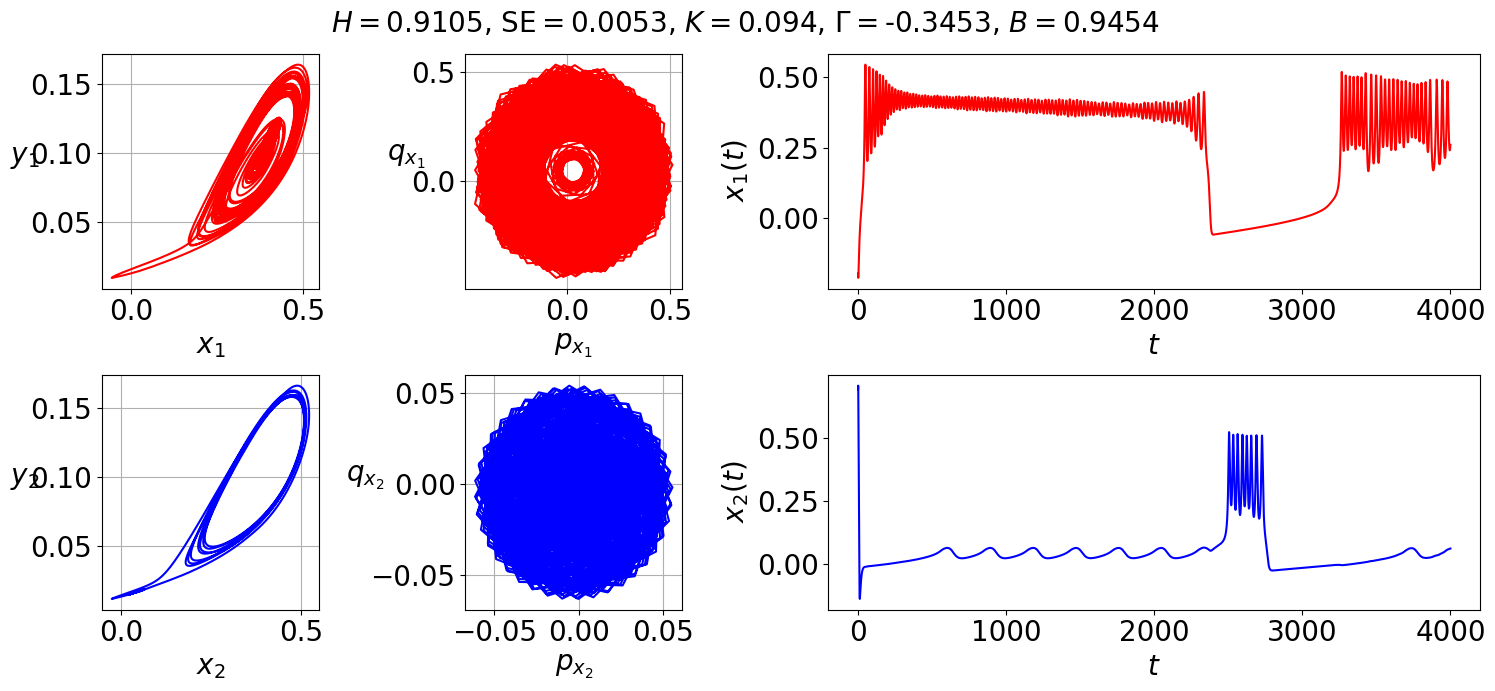

In [27]:
theta = -0.005
# theta = -0.001
# theta = 0.001
# theta = 0.01
# theta = 0.05
# theta =0.1

plotChemical(theta)

## Josephson junction coupling

<img src="JJSchem.png" width="300"/>

$\begin{aligned}
    \dot{x}_1 &= f(x_1, y_1, I_1) -I_c\sin(\phi) + \theta(x_2-x_1), \\
    \dot{x}_2 &= f(x_2, y_2, I_2) +I_c\sin(\phi) + \theta(x_1-x_2), \\
    \dot{y}_i &= g(x_i, y_i, I_i), \\
    \dot{I}_i & = h(x_i, y_i, I_i), \qquad i = 1,2, \\
    \dot{\phi} &= \mu(x_1 - x_2).
\end{aligned}$

In [29]:
def bif_JJ_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    beta = 3
    mu = 3
    print("theta=", theta)
    def system(t, vars):
        x1, y1, I1, x2, y2, I2, z= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1-beta*np.sin(z) + theta*(x2 - x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + beta*np.sin(z) + theta*(x1 - x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dzdt = mu*(x1-x2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dzdt]

    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022

    z_0 = mu*(x1_0 - x2_0)
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, z_0]

    t_span = (0, 4000) 
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    
    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("1. computing completed")

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("2. computing completed")
    

    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]


    ttKK = solutionKK.t
    
    def pq(phi, c):
        n = np.arange(len(phi))
        cosTerm = np.cos(c * n)
        sinTerm = np.sin(c * n)
        p = np.cumsum(phi * cosTerm)
        q = np.cumsum(phi * sinTerm)
        return p, q
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 20
    
    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("3. computing completed")

    h1, h2, se1, se2 = nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2

In [30]:
def plotJJ(theta):
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_JJ_pp(theta)
    
    sz=20
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
    fig.tight_layout()
    plt.suptitle(
        "$H=$" + str(round((h1 + h2) / 2, 4)) +
        ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
        ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
        ", $\Gamma=$" + str(round(cc, 4)) +
        ", $B=$" + str(round(Kuram, 4)),
        size=sz
    )
    
    axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
    # axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
    axs[0, 0].set_xlabel('$x_1$', size=sz)
    axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
    axs[0, 0].tick_params(axis='both', labelsize=sz)
    axs[0, 0].grid()

    axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
    # axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
    axs[1, 0].set_xlabel('$x_2$', size=sz)
    axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
    axs[1, 0].tick_params(axis='both', labelsize=sz)
    axs[1, 0].grid()
    
    axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
    axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
    axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
    axs[0, 1].tick_params(axis='both', labelsize=sz)
    axs[0, 1].grid()
    
    axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
    axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
    axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
    axs[1, 1].tick_params(axis='both', labelsize=sz)
    axs[1, 1].grid()
    
    axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
    axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
    axs[0, 2].set_xlabel('$t$', size=sz)
    axs[0, 2].tick_params(axis='both', labelsize=sz)
    
    axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
    axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
    axs[1, 2].set_xlabel('$t$', size=sz)
    axs[1, 2].tick_params(axis='both', labelsize=sz)
    
    plt.tight_layout()

theta= -1
-0.22177195704909347 0.2762193159554944
1. computing completed
2. computing completed
3. computing completed


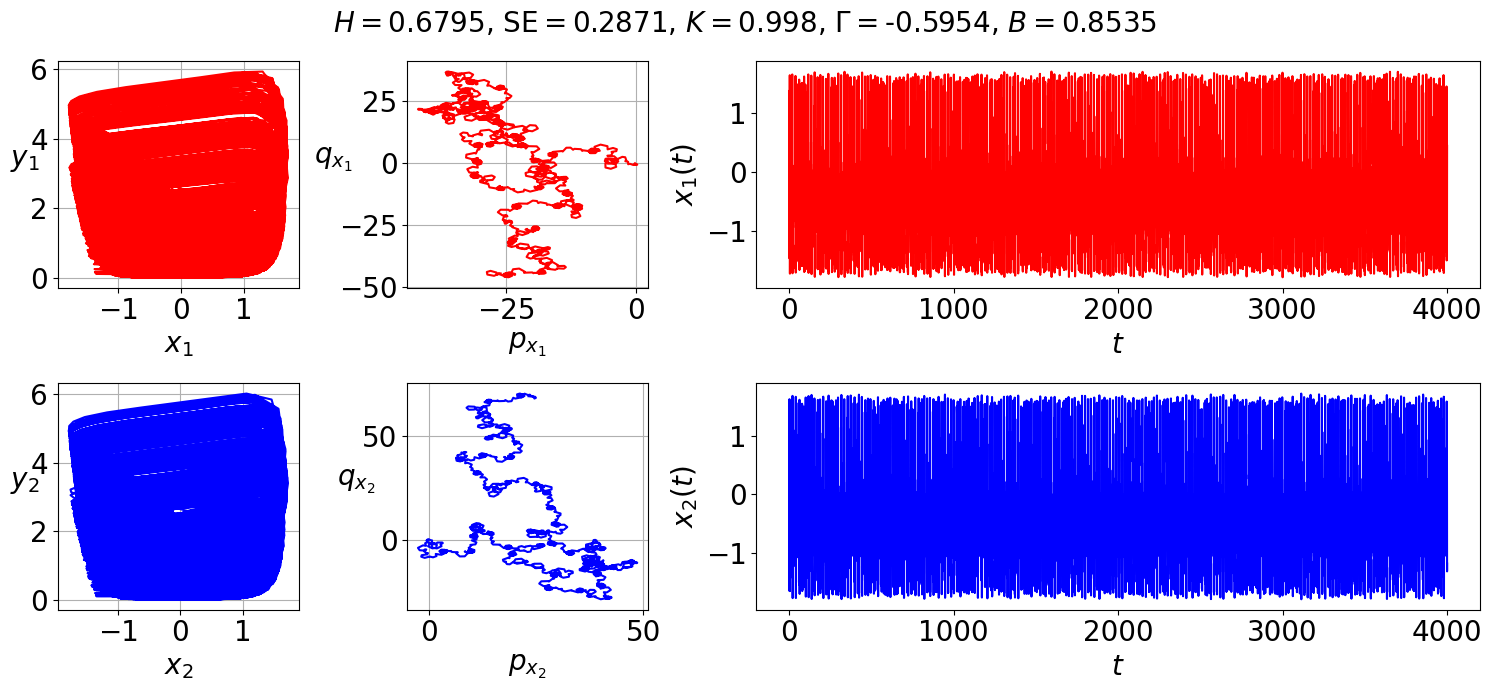

In [31]:
theta = -1
# theta = -.5
# theta = -.1
# theta = .1
# theta = 0.5
# theta =1

plotJJ(theta)

## Memristive coupling

<img src="mem_schem.png" width="200"/>

$\begin{aligned}
    \dot{x}_1 &= f(x_1, y_1, I_1) + \theta\rho(\phi)(x_2-x_1), \\
    \dot{x}_2 &= f(x_2, y_2, I_2) + \theta\rho(\phi)(x_1-x_2), \\
    \dot{y}_i &= g(x_i, y_i, I_i), \\
    \dot{I}_i & = h(x_i, y_i, I_i), \qquad i = 1,2, \\
    \dot{\phi} &= \theta(x_1 - x_2)
\end{aligned}$

In [35]:
def bif_mem_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    alpha = 10
    beta = 5
    
    print("theta=", theta)
    def rho(p): return alpha + 3*beta*p**2

    def system(t, vars):
        x1, y1, I1, x2, y2, I2, p= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1 + theta*rho(p)*(x2 - x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + theta*rho(p)*(x1 - x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dpdt = theta*(x1-x2)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dpdt]

    # Initial conditions
    x1_0 = np.random.uniform(low=-1, high=1)
    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)
    y2_0 = .1
    I2_0 = 0.022

    p_0 = theta*(x1_0 - x2_0)
    print(x1_0, x2_0)


    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, p_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]


    tt = solution.t
    
    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)

    Numerator = np.mean(x1_tilde*x2_tilde)
    Denominator = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    cc = Numerator/Denominator
    print("1. computing completed")

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Indt = np.abs(1/2*(Ind1+Ind2))
    Kuram = np.mean(Indt)
    print("2. computing completed")
    
    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]
    ttKK = solutionKK.t

    def pq(phi, c):
        n = np.arange(len(phi))
        cosTerm = np.cos(c * n)
        sinTerm = np.sin(c * n)
        p = np.cumsum(phi * cosTerm)
        q = np.cumsum(phi * sinTerm)
        return p, q
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 50

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    
    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
    print("3. computing completed")

    h1, h2, se1, se2 = nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.sampen(x1_sol), nd.sampen(x2_sol)
    print("4. computing completed")
    
    return x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2

In [36]:
def plotMem(theta):
    x1_sol, y1_sol, x2_sol, y2_sol, tt, cc, KK1, KK2, Kuram, h1, h2, se1, se2, p_x1, q_x1, p_x2, q_x2 = bif_mem_pp(theta)
    
    # phi_x1, phi_y1, phi_x2, phi_y2, KK1, se1, KK2, se2, kuram = [0.1, 0.2], [0.1, 0.2], [.1, .65], [0.1, 0.8], 1, 1, 1, 1, 1
    
    sz=20
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 3]})
    fig.tight_layout()
    plt.suptitle(
        "$H=$" + str(round((h1 + h2) / 2, 4)) +
        ", $\mathrm{SE}=$" + str(round((se1 + se2) / 2, 4)) +
        ", $K=$" + str(round((KK1 + KK2) / 2, 4)) +
        ", $\Gamma=$" + str(round(cc, 4)) +
        ", $B=$" + str(round(Kuram, 4)),
        size=sz
    )
    
    axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'r-', ms =1, rasterized=True)
    # axs[0, 0].plot(phi_x1, phi_y1, 'bo', ms =5, rasterized=True)
    axs[0, 0].set_xlabel('$x_1$', size=sz)
    axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
    axs[0, 0].tick_params(axis='both', labelsize=sz)
    axs[0, 0].grid()
    
    axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'b-', ms =1,  rasterized=True)
    # axs[1, 0].plot(phi_x2, phi_y2, 'ro', ms =5,  rasterized=True)
    axs[1, 0].set_xlabel('$x_2$', size=sz)
    axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
    axs[1, 0].tick_params(axis='both', labelsize=sz)
    axs[1, 0].grid()
    
    axs[0, 1].plot(p_x1, q_x1, 'r-', ms =1, rasterized=True)
    axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
    axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
    axs[0, 1].tick_params(axis='both', labelsize=sz)
    axs[0, 1].grid()
    
    axs[1, 1].plot(p_x2, q_x2, 'b-', ms =1, rasterized=True)
    axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
    axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
    axs[1, 1].tick_params(axis='both', labelsize=sz)
    axs[1, 1].grid()
    
    axs[0, 2].plot(tt, x1_sol, 'r-', ms=1, rasterized=True)
    axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
    axs[0, 2].set_xlabel('$t$', size=sz)
    axs[0, 2].tick_params(axis='both', labelsize=sz)
    
    axs[1, 2].plot(tt, x2_sol, 'b-', ms=1, rasterized=True)
    axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
    axs[1, 2].set_xlabel('$t$', size=sz)
    axs[1, 2].tick_params(axis='both', labelsize=sz)

    plt.tight_layout()

theta= 0.01
-0.967275620551828 0.7388920571749502
1. computing completed
2. computing completed
3. computing completed
4. computing completed


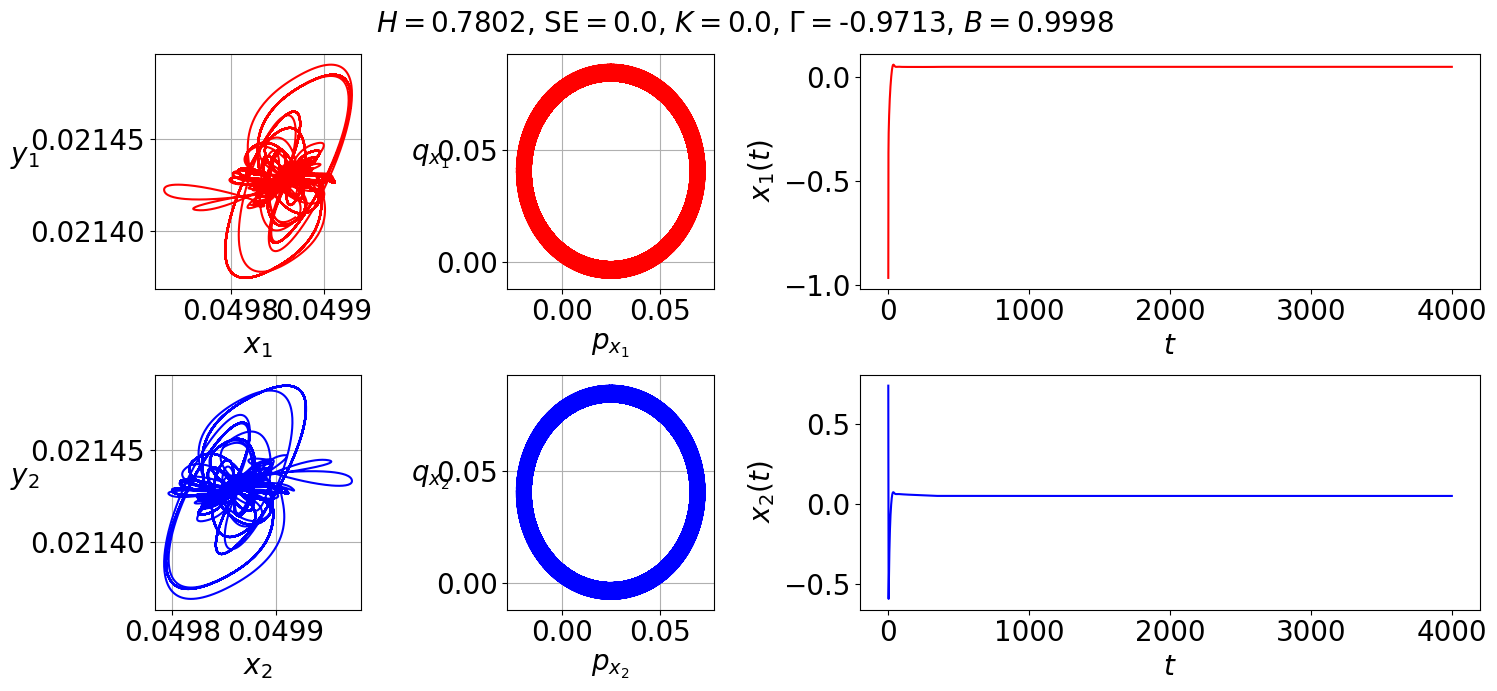

In [37]:
# theta = -0.02
# theta = -.01
# theta = -0.005
# theta = 0.002
# theta = 0.005
theta = 0.01

plotMem(theta)

## Higher-order gap junction coupling in the smallest ring-star network

<!-- <img src="HO_A.png" width="200"/> -->

<table>
  <td><img src="HO_A.png" width="200"/></td>
  <td><img src="HO_B.png" width="200"/></td>
  <td><img src="HO_C.png" width="200"/></td>
  <td><img src="HO_D.png" width="200"/></td>
  <td><img src="HO_E.png" width="200"/></td>
</table>

$\begin{aligned}
    \dot{x}_1 &= f(x_1, y_1, I_1) + (\mu + 2\theta)(x_2+x_3+x_4 - 3x_1), \\
    \dot{x}_2 &= f(x_2, y_2, I_2) + \mu(x_1 - x_2) + \sigma(x_3+x_4-2x_2) \\ &+ 2\theta(x_1+x_3+x_4 - 3x_2),\\
    \dot{x}_3 &= f(x_3, y_3, I_3) + \mu(x_1 - x_3) + \sigma(x_2+x_4-2x_3) \\
    &+ 2\theta(x_1+x_2+x_4 - 3x_3),\\
    \dot{x}_4 &= f(x_4, y_4, I_4) + \mu(x_1 - x_4) + \sigma(x_2+x_3-2x_4) \\ 
    &+ 2\theta(x_1+x_2+x_3 - 3x_4),\\
    \dot{y}_i &= g(x_i, y_i, I_i), \\
    \dot{I}_i & = h(x_i, y_i, I_i), \qquad i = 1,\ldots, 4.
\end{aligned}$

In [38]:
def bif_ho_pp(theta):
    A = 0.0041
    alpha=5.276
    gamma = 0.315
    epsilon = 0.0005

    mu = .01
    sigma = .01

    def system(t, vars):
        x1, y1, I1, x2, y2, I2, x3, y3, I3, x4, y4, I4= vars
        dx1dt = x1**2 * (1 - x1) - y1 + I1+ mu * (x2+x3+x4 - 3*x1) + 2*theta*(x2+x3+x4-3*x1)
        dy1dt = A * np.exp(alpha * x1) - gamma * y1
        dI1dt = epsilon*(1/60*(1+np.tanh((0.05-x1)/0.001)) - I1)
        dx2dt = x2**2 * (1 - x2) - y2 + I2 + mu * (x1 - x2) +sigma*(x3+x4-2*x2) + 2*theta*(x1+x3+x4 - 3*x2)
        dy2dt = A * np.exp(alpha * x2) - gamma * y2
        dI2dt = epsilon*(1/60*(1+np.tanh((0.05-x2)/0.001)) - I2)
        dx3dt = x3**2 * (1 - x3) - y3 + I3+ mu * (x1 - x3) +sigma*(x2+x4-2*x3) + 2*theta*(x1+x2+x4 - 3*x3)
        dy3dt = A * np.exp(alpha * x3) - gamma * y3
        dI3dt = epsilon*(1/60*(1+np.tanh((0.05-x3)/0.001)) - I3)
        dx4dt = x4**2 * (1 - x4) - y4 + I4 + mu * (x1 - x4) +sigma*(x2+x3-2*x4) + 2*theta*(x1+x2+x3 - 3*x4)
        dy4dt = A * np.exp(alpha * x4) - gamma * y4
        dI4dt = epsilon*(1/60*(1+np.tanh((0.05-x4)/0.001)) - I4)

        return [dx1dt, dy1dt, dI1dt, dx2dt, dy2dt, dI2dt, dx3dt, dy3dt, dI3dt, dx4dt, dy4dt, dI4dt]

    x1_0 = np.random.uniform(low=-1, high=1)

    y1_0 = 0.1
    I1_0 = 0.018

    x2_0 = np.random.uniform(low=-1, high=1)

    y2_0 = .1
    I2_0 = 0.019

    x3_0 = np.random.uniform(low=-1, high=1)
    y3_0 = 0.1
    I3_0 = 0.02


    x4_0 = np.random.uniform(low=-1, high=1)
    y4_0 = .1
    I4_0 = 0.022

    initial_conditions = [x1_0, y1_0, I1_0, x2_0, y2_0, I2_0, x3_0, y3_0, I3_0, x4_0, y4_0, I4_0]

    t_span = (0, 4000)
    t_eval = np.linspace(t_span[0], t_span[1], 50000)

    solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    x1_sol = solution.y[0]
    y1_sol = solution.y[1]
    I1_sol = solution.y[2]

    x2_sol = solution.y[3]
    y2_sol = solution.y[4]
    I2_sol = solution.y[5]

    x3_sol = solution.y[6]
    y3_sol = solution.y[7]
    I3_sol = solution.y[8]

    x4_sol = solution.y[9]
    y4_sol = solution.y[10]
    I4_sol = solution.y[11]

    tt = solution.t

    phi_x1 = np.array(x1_sol[5000:])
    phi_x2 = np.array(x2_sol[5000:])
    phi_x3 = np.array(x3_sol[5000:])
    phi_x4 = np.array(x4_sol[5000:])
    
    x1_tilde = phi_x1 - np.mean(phi_x1)
    x2_tilde = phi_x2 - np.mean(phi_x2)
    x3_tilde = phi_x3 - np.mean(phi_x3)
    x4_tilde = phi_x4 - np.mean(phi_x4)

    Numerator2 = np.mean(x1_tilde*x2_tilde)
    Denominator2 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x2_tilde**2))
    
    Numerator3 = np.mean(x1_tilde*x3_tilde)
    Denominator3 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x3_tilde**2))
    
    Numerator4 = np.mean(x1_tilde*x4_tilde)
    Denominator4 = np.sqrt(np.mean(x1_tilde**2)*np.mean(x4_tilde**2))
    
    cc = (Numerator2/Denominator2 + Numerator3/Denominator3+ Numerator4/Denominator4)/3
    print("1. computing completed")
    

    l1 = np.arctan(y1_sol/x1_sol)
    l2 = np.arctan(y2_sol/x2_sol)
    l3 = np.arctan(y3_sol/x3_sol)
    l4 = np.arctan(y4_sol/x4_sol)

    Ind1 = np.exp(1j*l1)
    Ind2 = np.exp(1j*l2)
    Ind3 = np.exp(1j*l3)
    Ind4 = np.exp(1j*l4)
    Indt = np.abs(1/4*(Ind1+Ind2+Ind3+Ind4))
    Kuram = np.mean(Indt)
    print("2. computing completed")

    t_spanKK = (0, 4000)
    t_evalKK = np.linspace(t_spanKK[0], t_spanKK[1], 10000)

    solutionKK = solve_ivp(system, t_spanKK, initial_conditions, t_eval=t_evalKK, method='RK45')

    
    x1_solKK = solutionKK.y[0]
    y1_solKK = solutionKK.y[1]
    I1_solKK = solutionKK.y[2]

    x2_solKK = solutionKK.y[3]
    y2_solKK = solutionKK.y[4]
    I2_solKK = solutionKK.y[5]

    x3_solKK = solutionKK.y[6]
    y3_solKK = solutionKK.y[7]
    I3_solKK = solutionKK.y[8]

    x4_solKK = solutionKK.y[9]
    y4_solKK = solutionKK.y[10]
    I4_solKK = solutionKK.y[11]

    ttKK = solutionKK.t
    
    def pq(phi, c):
        n = np.arange(len(phi))
        cosTerm = np.cos(c * n)
        sinTerm = np.sin(c * n)
        p = np.cumsum(phi * cosTerm)
        q = np.cumsum(phi * sinTerm)
        return p, q
    
    def Mn_c(phi, c, ncut):
        p, q = pq(phi, c)
        N = len(phi) - ncut
        Mn = np.zeros(ncut)
        for n in range(0, ncut):
            Mn[n] = np.mean([(p[j+n] - p[j])**2 + (q[j+n] - q[j])**2 for j in range(0, N)])
        return Mn

    def Vosc_c(phi, c, ncut):
        E_phi = np.mean(phi)
        return [E_phi**2 * (1 - np.cos(n*c))/(1 - np.cos(c)) for n in range(0, ncut)]

    def Dn_c(phi, c, ncut):
        return Mn_c(phi, c, ncut) - Vosc_c(phi, c, ncut)

    def correlation_method(phi, ncut):
        eps = np.arange(1, ncut + 1)
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c = [pearsonr(eps, Dn_c(phi, c, ncut))[0] for c in c_range]
        valid_indices = np.where(~np.isnan(K_c))[0]
        return np.median(np.array(K_c)[valid_indices])

    def Dn_c_tilde(phi, c, ncut):
        Dn = Dn_c(phi, c, ncut)
        return Dn - np.min(Dn)

    def K_c(phi, c, ncut):
        Mn = Mn_c(phi, c, ncut)
        return np.log(Mn + 1e-5) / np.log(np.arange(1, ncut+1))

    def Kc(phi, c, ncut):
        def linear_func(x, *p):
            return p[0] + p[1] * x

        fit_params, _ = curve_fit(linear_func, np.log(np.arange(1, ncut+1)), np.log(Dn_c_tilde(phi, c, ncut)[:ncut] + 1e-2), [0, 0.5])

        return fit_params[1]

    def regression_method(phi, ncut):
        c_range = np.arange(0.01, 2*np.pi, 0.01)
        K_c_values = [Kc(phi, c, ncut) for c in c_range]
        return np.median(K_c_values)
    
    c = 1.1
    ncut2 = 50

    phi_x1 = x1_solKK[8000:]
    phi_y1 = y1_solKK[8000:]
    phi_x2 = x2_solKK[8000:]
    phi_y2 = y2_solKK[8000:]
    phi_x3 = x3_solKK[8000:]
    phi_y3 = y3_solKK[8000:]
    phi_x4 = x4_solKK[8000:]
    phi_y4 = y4_solKK[8000:]
    
    p_x1, q_x1 = pq(phi_x1, c)
    p_x2, q_x2 = pq(phi_x2, c)
    p_x3, q_x3 = pq(phi_x3, c)
    p_x4, q_x4 = pq(phi_x4, c)

    if theta <0:
        KK1 = correlation_method(phi_x1, ncut2)
        KK2 = correlation_method(phi_x2, ncut2)
        KK3 = correlation_method(phi_x3, ncut2)
        KK4 = correlation_method(phi_x4, ncut2)
    else:
        KK1 = regression_method(phi_x1, ncut2)
        KK2 = regression_method(phi_x2, ncut2)
        KK3 = regression_method(phi_x3, ncut2)
        KK4 = regression_method(phi_x4, ncut2)
    print("3. computing completed")

    h1, h2, h3, h4, se1, se2, se3, se4 = nd.hurst_rs(x1_sol), nd.hurst_rs(x2_sol), nd.hurst_rs(x3_sol), nd.hurst_rs(x4_sol), nd.sampen(x1_sol), nd.sampen(x2_sol), nd.sampen(x3_sol), nd.sampen(x4_sol)
    return x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, h1, h2, h3, h4, se1, se2, se3, se4 , p_x1, q_x1, p_x2, q_x2, p_x3, q_x3, p_x4, q_x4

In [39]:
def plotHO(theta):    
    x1_sol, y1_sol, x2_sol, y2_sol, x3_sol, y3_sol, x4_sol, y4_sol, tt, cc, KK1, KK2, KK3, KK4, Kuram, h1, h2, h3, h4, se1, se2, se3, se4, p_x1, q_x1, p_x2, q_x2, p_x3, q_x3, p_x4, q_x4 = bif_ho_pp(theta)
    
    sz=20
    
    fig, axs = plt.subplots(4, 3, figsize=(15, 14), gridspec_kw={'width_ratios': [1, 1, 3]})
    fig.tight_layout()
    plt.suptitle(
        "$H=$" + str(round((h1 + h2 + h3+ h4) / 4, 4)) +
        ", $\mathrm{SE}=$" + str(round((se1 + se2 + se3 + se4) / 4, 4)) +
        ", $K=$" + str(round((KK1 + KK2 + KK3+ KK4) / 4, 4)) +
        ", $\Gamma=$" + str(round(cc, 4)) +
        ", $B=$" + str(round(Kuram, 4)),
        size=sz
    )
    
    axs[0, 0].plot(x1_sol[5000:], y1_sol[5000:], 'k-', ms =1, rasterized=True)
    axs[0, 0].set_xlabel('$x_1$', size=sz)
    axs[0, 0].set_ylabel('$y_1$', rotation = False, size=sz)
    axs[0, 0].tick_params(axis='both', labelsize=sz)
    axs[0, 0].grid()
    
    axs[1, 0].plot(x2_sol[5000:], y2_sol[5000:], 'r-', ms =1,  rasterized=True)
    axs[1, 0].set_xlabel('$x_2$', size=sz)
    axs[1, 0].set_ylabel('$y_2$', rotation=False, size=sz)
    axs[1, 0].tick_params(axis='both', labelsize=sz)
    axs[1, 0].grid()
    
    axs[2, 0].plot(x3_sol[5000:], y3_sol[5000:], 'g-', ms =1, rasterized=True)
    axs[2, 0].set_xlabel('$x_3$', size=sz)
    axs[2, 0].set_ylabel('$y_3$', rotation = False, size=sz)
    axs[2, 0].tick_params(axis='both', labelsize=sz)
    axs[2, 0].grid()
    
    axs[3, 0].plot(x4_sol[5000:], y4_sol[5000:], 'b-', ms =1,  rasterized=True)
    axs[3, 0].set_xlabel('$x_4$', size=sz)
    axs[3, 0].set_ylabel('$y_4$', rotation=False, size=sz)
    axs[3, 0].tick_params(axis='both', labelsize=sz)
    axs[3, 0].grid()
    
    axs[0, 1].plot(p_x1, q_x1, 'k-', ms =1, rasterized=True)
    axs[0, 1].set_xlabel('$p_{x_1}$', size=sz)
    axs[0, 1].set_ylabel('$q_{x_1}$', rotation = False, size=sz)
    axs[0, 1].tick_params(axis='both', labelsize=sz)
    axs[0, 1].grid()
    
    axs[1, 1].plot(p_x2, q_x2, 'r-', ms =1, rasterized=True)
    axs[1, 1].set_xlabel('$p_{x_2}$', size=sz)
    axs[1, 1].set_ylabel('$q_{x_2}$', rotation = False, size=sz)
    axs[1, 1].tick_params(axis='both', labelsize=sz)
    axs[1, 1].grid()
    
    axs[2, 1].plot(p_x3, q_x3, 'g-', ms =1, rasterized=True)
    axs[2, 1].set_xlabel('$p_{x_3}$', size=sz)
    axs[2, 1].set_ylabel('$q_{x_3}$', rotation = False, size=sz)
    axs[2, 1].tick_params(axis='both', labelsize=sz)
    axs[2, 1].grid()
    
    axs[3, 1].plot(p_x4, q_x4, 'b-', ms =1, rasterized=True)
    axs[3, 1].set_xlabel('$p_{x_4}$', size=sz)
    axs[3, 1].set_ylabel('$q_{x_4}$', rotation = False, size=sz)
    axs[3, 1].tick_params(axis='both', labelsize=sz)
    axs[3, 1].grid()
    
    axs[0, 2].plot(tt, x1_sol, 'k-', ms=1, rasterized=True)
    axs[0, 2].set_ylabel('$x_1(t)$', size=sz)
    axs[0, 2].set_xlabel('$t$', size=sz)
    axs[0, 2].tick_params(axis='both', labelsize=sz)
    
    axs[1, 2].plot(tt, x2_sol, 'r-', ms=1, rasterized=True)
    axs[1, 2].set_ylabel('$x_2(t)$', size=sz)
    axs[1, 2].set_xlabel('$t$', size=sz)
    axs[1, 2].tick_params(axis='both', labelsize=sz)
    
    axs[2, 2].plot(tt, x3_sol, 'g-', ms=1, rasterized=True)
    axs[2, 2].set_ylabel('$x_3(t)$', size=sz)
    axs[2, 2].set_xlabel('$t$', size=sz)
    axs[2, 2].tick_params(axis='both', labelsize=sz)
    
    axs[3, 2].plot(tt, x4_sol, 'b-', ms=1, rasterized=True)
    axs[3, 2].set_ylabel('$x_4(t)$', size=sz)
    axs[3, 2].set_xlabel('$t$', size=sz)
    axs[3, 2].tick_params(axis='both', labelsize=sz)
    
    plt.tight_layout()

1. computing completed
2. computing completed
3. computing completed


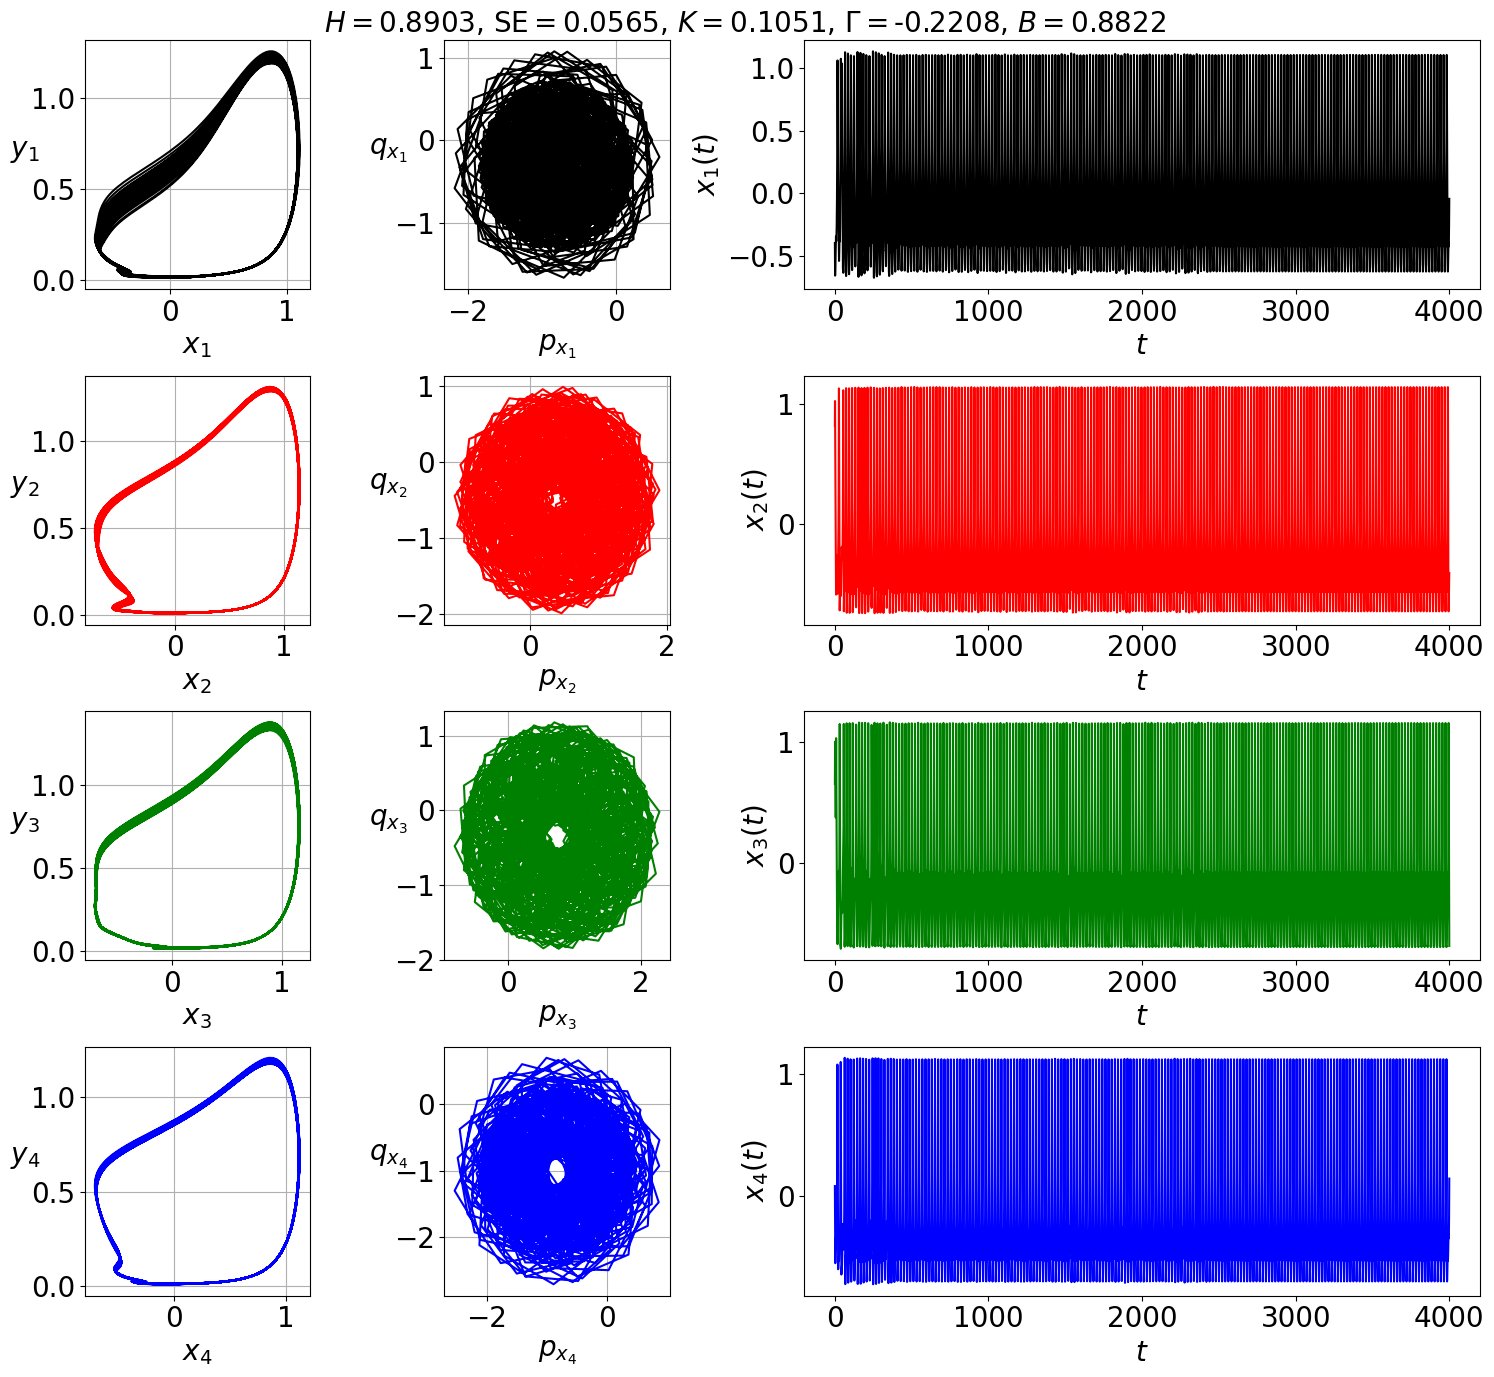

In [40]:
theta = -0.1
# theta = -0.05
# theta = -0.01
# theta = 0.01
# theta = 0.05
# theta = 0.1

plotHO(theta)